# Stepwise selection 
### with sklearn for regression

## Imports

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

## Load data

In [16]:
x = load_boston()
ds = pd.DataFrame(x.data, columns = x.feature_names)
ds["MEDV"] = x.target
X = ds.drop("MEDV",1)   
y = ds["MEDV"]          
ds.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Correlation analysis

#### Correlation among covariates

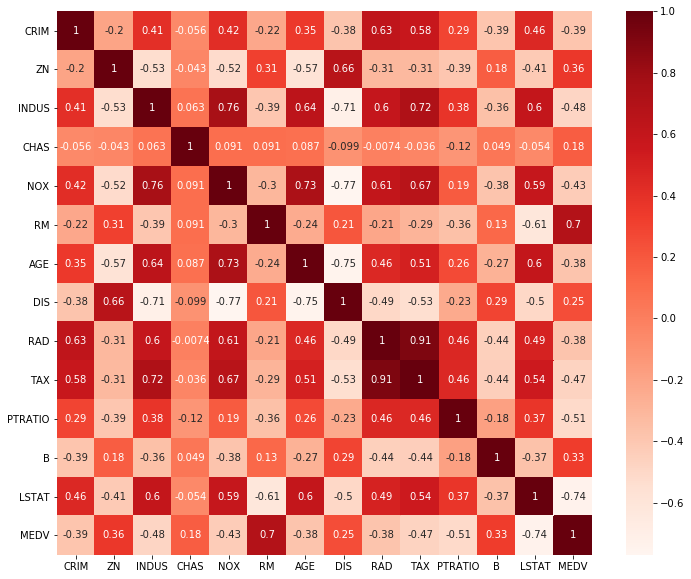

In [17]:
plt.figure(figsize=(12,10))
cor = ds.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Correlation with response

In [18]:
cor = abs(cor["MEDV"])

print(cor)
relevant_features = cor[cor > 0.5]
print('\n Relevant features \n')
print(relevant_features)

CRIM       0.388305
ZN         0.360445
INDUS      0.483725
CHAS       0.175260
NOX        0.427321
RM         0.695360
AGE        0.376955
DIS        0.249929
RAD        0.381626
TAX        0.468536
PTRATIO    0.507787
B          0.333461
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

 Relevant features 

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64


## Backward elimination (with linear model)

In [22]:
X_1 = sm.add_constant(X)
model = sm.OLS(y, X_1).fit()
model.pvalues

const      3.283438e-12
CRIM       1.086810e-03
ZN         7.781097e-04
INDUS      7.382881e-01
CHAS       1.925030e-03
NOX        4.245644e-06
RM         1.979441e-18
AGE        9.582293e-01
DIS        6.013491e-13
RAD        5.070529e-06
TAX        1.111637e-03
PTRATIO    1.308835e-12
B          5.728592e-04
LSTAT      7.776912e-23
dtype: float64

In [23]:
cols = list(X.columns)
pmax = 1
while (len(cols) > 0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
print('Selected :', cols)

Selected : ['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


## Recursive Feature Elimination

In [29]:
model = LinearRegression()
rfe = RFE(model, 7) 
X_rfe = rfe.fit_transform(X, y)  
model.fit(X_rfe, y)
print(rfe.support_)
print(rfe.ranking_)

[False False False  True  True  True False  True  True False  True False
  True]
[2 4 3 1 1 1 7 1 1 5 1 6 1]


In [32]:
n_feats = np.arange(1,13)            
scores = []
best_n_feat = 0           
best_score = 0
for n in range(len(n_feat)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,n_feats[n])
    
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_test_rfe, y_test)
    scores.append(score)
    if(score > high_score):
        best_score = score
        best_n_feat = n_feats[n]

print('Optimum number of features: ', best_n_feat)
print('Score : ', round(best_score,2))

Optimum number of features:  12
Score :  0.66


In [38]:
cols = list(X.columns)
model = LinearRegression()
rfe = RFE(model, 10)             

X_rfe = rfe.fit_transform(X,y)  
model.fit(X_rfe,y)              

sel = pd.Series(rfe.support_,index = cols)
selected_features = sel[sel==True].index
print(selected_features.values)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'DIS' 'RAD' 'PTRATIO' 'LSTAT']


## Embedded elimination

In [41]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444
Lasso picked 10 variables and eliminated the other 3 variables


In [40]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 10 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

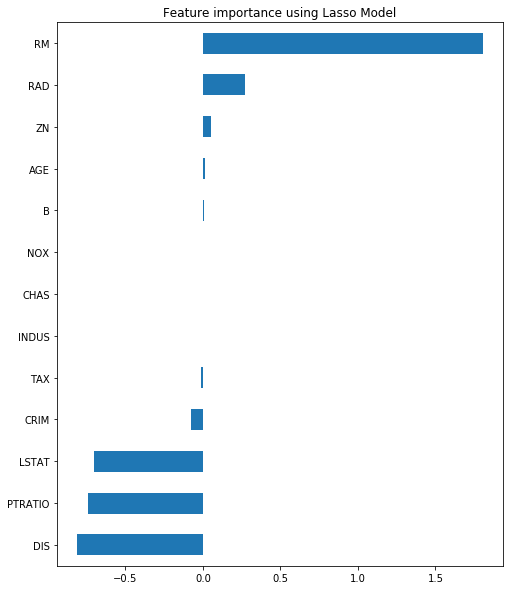

In [43]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

## Credits & Links

https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b